## **Pré-Processamento Pós EDA**
* Conversando com a Fernanda percebemos que nossa análise é sobre a partida então features de estatísticas gerais dos times não ou pouco importariam para o nosso clustering.
* Outra questão que percebemos também é que existem features do Time B que podem dizer comportamentos do time A (um time B com muitos erros pode indicar também um time A com alta Hit Pct). Então decidimos voltar atrás na retirada das colunas do time B
* Como times variam bastante de jogadores de um ano para o outro, decidimos diferenciar um time A de 2019 de um time A de 2018.
* para identificar isso iremos criar alguns ids como ID da Partida e ID do time naquele ano

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("C:/Users/gabri/OneDrive/Documents/Faculdade/2024.2/Projeto de Ciência de Dados/novo/volleyball-case-study/data/para-o-projeto/team_v_team.csv")
df.head()

,Unnamed: 0,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,...,Team B Hit Pct,Team B Assists,Team B Aces,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS
0,0,8302019,USC Upstate,Virginia Tech,0,4.0,33,21,112,0.107,...,0.234,48,13,12,51,4,4,20,2,0.0
1,1,8302019,USC Upstate,Northwestern,0,3.0,16,24,89,-0.090,...,0.349,41,6,7,42,1,2,20,0,0.0
2,2,9072019,USC Upstate,Ga. Southern,0,3.0,37,20,117,0.145,...,0.239,39,4,5,49,2,1,6,1,50.0
3,3,9132019,USC Upstate,Norfolk St.,1,5.0,50,27,164,0.140,...,0.114,47,11,15,67,9,1,17,1,70.5
4,4,9142019,USC Upstate,George Washington,0,3.0,30,17,112,0.116,...,0.216,44,3,1,60,2,1,6,6,52.0


In [4]:
def format_date(date):
    date_str = str(date)  # Converte o inteiro para string
    if len(date_str) == 7:  # Caso a data tenha 7 caracteres (mês ou dia com um único dígito)
        return pd.to_datetime(date_str, format='%m%d%Y')
    else:
        return pd.to_datetime(date_str, format='%m%d%Y')

# Aplicar a função de formatação às datas
df['Date'] = df['Date'].apply(format_date)
df = df.drop(columns=["Unnamed: 0"])

### **Feature Engineering**

In [5]:
# Gerando colunas para obter eficiência geral

df["Team A Total Errors"] = df['Team A Errors'] + df['Team A SErr'] + df['Team A BErr'] + df['Team A RErr']
df["Team B Total Errors"] = df['Team B Errors'] + df['Team B SErr'] + df['Team B BErr'] + df['Team B RErr']
df["Team A Total Rounds"] = df['Team A PTS'] + df['Team A Total Errors']
df["Team B Total Rounds"] = df['Team B PTS'] + df['Team B Total Errors']
df["Team A Efficiency Rate"] = df["Team A PTS"] - df["Team A Total Errors"] / df["Team A Total Rounds"]
df["Team B Efficiency Rate"] = df["Team B PTS"] - df["Team B Total Errors"] / df["Team B Total Rounds"]

# Gerando colunas para obter eficiência de bloqueio

df["Team A Total Blocks"] = df['Team A Block Solos'] + df['Team A Block Assists']*0.5 + df['Team A BErr']
df["Team B Total Blocks"] = df['Team B Block Solos'] + df['Team B Block Assists']*0.5 + df['Team B BErr']
df["Team A Success Blocks"]= df['Team A Block Solos'] + df['Team A Block Assists']*0.5
df["Team B Success Blocks"]= df['Team B Block Solos'] + df['Team B Block Assists']*0.5
df["Team A Block Efficiency"] = df["Team A Success Blocks"] / df["Team A Total Blocks"]
df["Team B Block Efficiency"] = df["Team B Success Blocks"] / df["Team B Total Blocks"]

# Gerando colunas para obter a eficiência de defesa

df["Team A Total Digs"] = df['Team A Digs'] + df['Team A RErr']
df["Team B Total Digs"] = df['Team B Digs'] + df['Team B RErr']
df["Team A Efficiency Digs"] = df["Team A Digs"] / df["Team A Total Digs"]
df["Team B Efficiency Digs"] = df["Team B Digs"]  / df["Team B Total Digs"]

ind_remocao = df["Team A Total Errors"].loc[df["Team A Total Errors"] == 0].index
df.drop(ind_remocao, inplace=True)

# ind_remocao = df["Team A Block Efficiency"].loc[df["Team A Block Efficiency"] == 0].index
# df.drop(ind_remocao, inplace=True)
# ind_remocao = df["Team B Block Efficiency"].loc[df["Team B Block Efficiency"] == 0].index
# df.drop(ind_remocao, inplace=True)

ind_remocao = df["Team B Total Blocks"].loc[df["Team B Total Blocks"] == 0].index
df.drop(ind_remocao, inplace=True)
ind_remocao = df["Team A Total Blocks"].loc[df["Team A Total Blocks"] == 0].index
df.drop(ind_remocao, inplace=True)


In [6]:
# Criando um dicionário para mapear os IDs dos times
team_ids = {team: idx for idx, team in enumerate(set(df["TeamA"]).union(df["TeamB"]))}

# Adicionando colunas de IDs de time
df["TeamA_ID"] = df["TeamA"].map(team_ids)
df["TeamB_ID"] = df["TeamB"].map(team_ids)

# Criando a coluna de ID da partida, garantindo que os jogos reversos tenham o mesmo ID
df["Match_ID"] = df.apply(lambda row: (row["Date"], tuple(sorted([row["TeamA_ID"], row["TeamB_ID"]]))), axis=1)

# Convertendo a combinação (data, time A ID, time B ID) em um identificador numérico único
df["Match_ID"] = df["Match_ID"].apply(lambda x: hash(x))


### **Verificando Distribuição dos Dados em Relação a Normal**

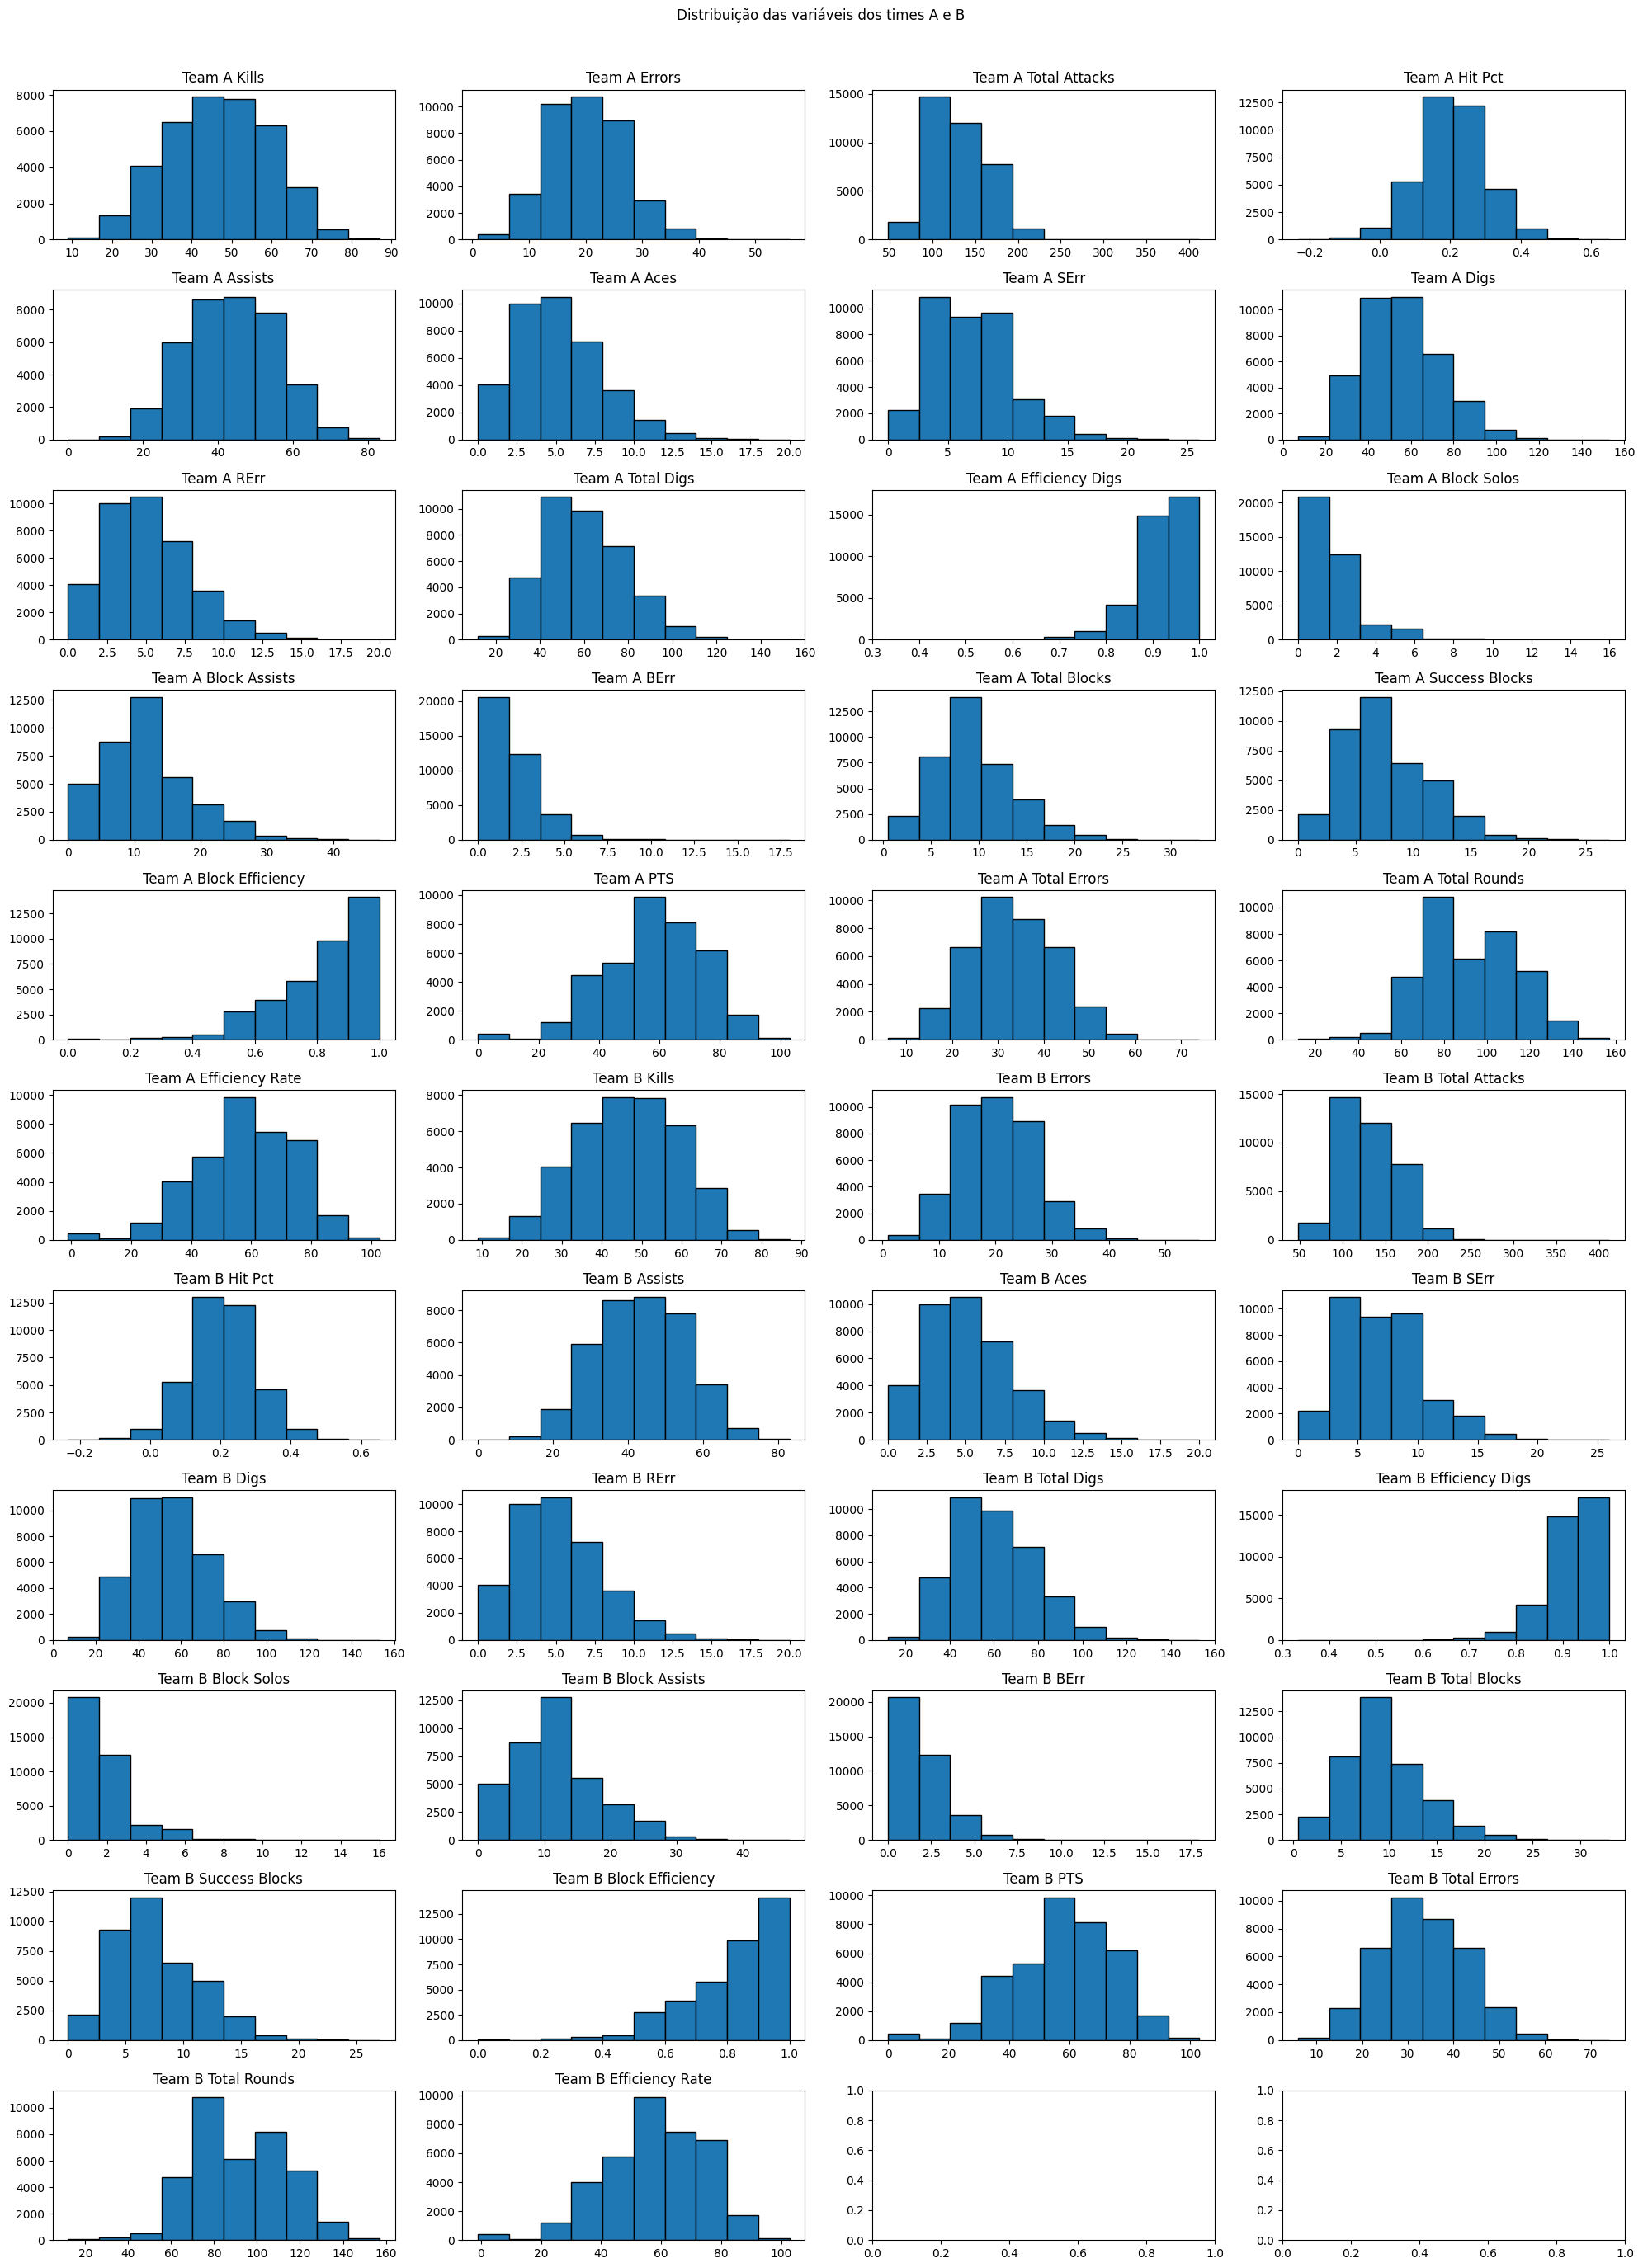

In [7]:
fig, axs = plt.subplots(11, 4, figsize=(20, 28))
fig.suptitle('Distribuição das variáveis dos times A e B')

colunas = df.columns

colunas_verify = [ 'Team A Kills',
       'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
       'Team A Assists', 'Team A Aces', 'Team A SErr', 'Team A Digs',
       'Team A RErr', 'Team A Total Digs', 'Team A Efficiency Digs',
       'Team A Block Solos', 'Team A Block Assists', 'Team A BErr',
       'Team A Total Blocks', 'Team A Success Blocks', 'Team A Block Efficiency',
       'Team A PTS', 'Team A Total Errors', 'Team A Total Rounds',
       'Team A Efficiency Rate', 'Team B Kills', 'Team B Errors',
       'Team B Total Attacks', 'Team B Hit Pct', 'Team B Assists',
       'Team B Aces', 'Team B SErr', 'Team B Digs', 'Team B RErr',
       'Team B Total Digs', 'Team B Efficiency Digs',
       'Team B Block Solos', 'Team B Block Assists', 'Team B BErr',
       'Team B Total Blocks', 'Team B Success Blocks', 'Team B Block Efficiency',
       'Team B PTS', 'Team B Total Errors', 'Team B Total Rounds',
       'Team B Efficiency Rate']

axs = axs.ravel()

for i, col in enumerate(colunas_verify):
    axs[i].hist(df[col], bins=10, edgecolor='black')
    axs[i].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [8]:
scaler = MinMaxScaler()
df_norm = df
df_norm[colunas_verify] = scaler.fit_transform(df[colunas_verify])
df_norm


,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B Success Blocks,Team A Block Efficiency,Team B Block Efficiency,Team A Total Digs,Team B Total Digs,Team A Efficiency Digs,Team B Efficiency Digs,TeamA_ID,TeamB_ID,Match_ID
0,2019-08-30,USC Upstate,Virginia Tech,0,4.0,0.307692,0.363636,0.175824,0.384181,0.361446,...,0.518519,0.875000,0.875000,0.304965,0.304965,0.645455,0.890909,118,106,-7623327459230903434
1,2019-08-30,USC Upstate,Northwestern,0,3.0,0.089744,0.418182,0.112637,0.161582,0.180723,...,0.444444,0.833333,1.000000,0.156028,0.219858,0.735294,0.965116,118,211,3808648007972125505
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,0.358974,0.345455,0.189560,0.427119,0.421687,...,0.148148,0.714286,0.800000,0.283688,0.276596,0.884615,0.941176,118,127,2899310916408534022
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,0.525641,0.472727,0.318681,0.421469,0.566265,...,0.351852,1.000000,0.904762,0.531915,0.453901,0.810345,0.822368,118,141,-8437588409357630576
4,2019-09-14,USC Upstate,George Washington,0,3.0,0.269231,0.290909,0.175824,0.394350,0.361446,...,0.148148,1.000000,0.400000,0.234043,0.354610,0.900000,0.951613,118,161,6300998361499773776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37645,2016-11-01,Elon,N.C. Central,1,3.0,0.551282,0.236364,0.159341,0.667797,0.602410,...,0.148148,0.600000,0.444444,0.269504,0.177305,0.940000,0.837838,197,93,-8965062542845588622
37646,2016-11-05,Elon,Col. of Charleston,0,3.0,0.384615,0.363636,0.211538,0.425989,0.421687,...,0.222222,0.500000,0.600000,0.312057,0.397163,0.892857,0.845588,197,174,7918146445281467354
37647,2016-11-07,Elon,UNCW,0,3.0,0.448718,0.490909,0.228022,0.401130,0.481928,...,0.388889,0.666667,0.840000,0.326241,0.262411,0.896552,0.969388,197,284,819597093055936531
37648,2016-11-11,Elon,Hofstra,0,5.0,0.512821,0.654545,0.296703,0.350282,0.542169,...,0.333333,1.000000,1.000000,0.453901,0.326241,0.822368,0.896552,197,49,659306623337739034


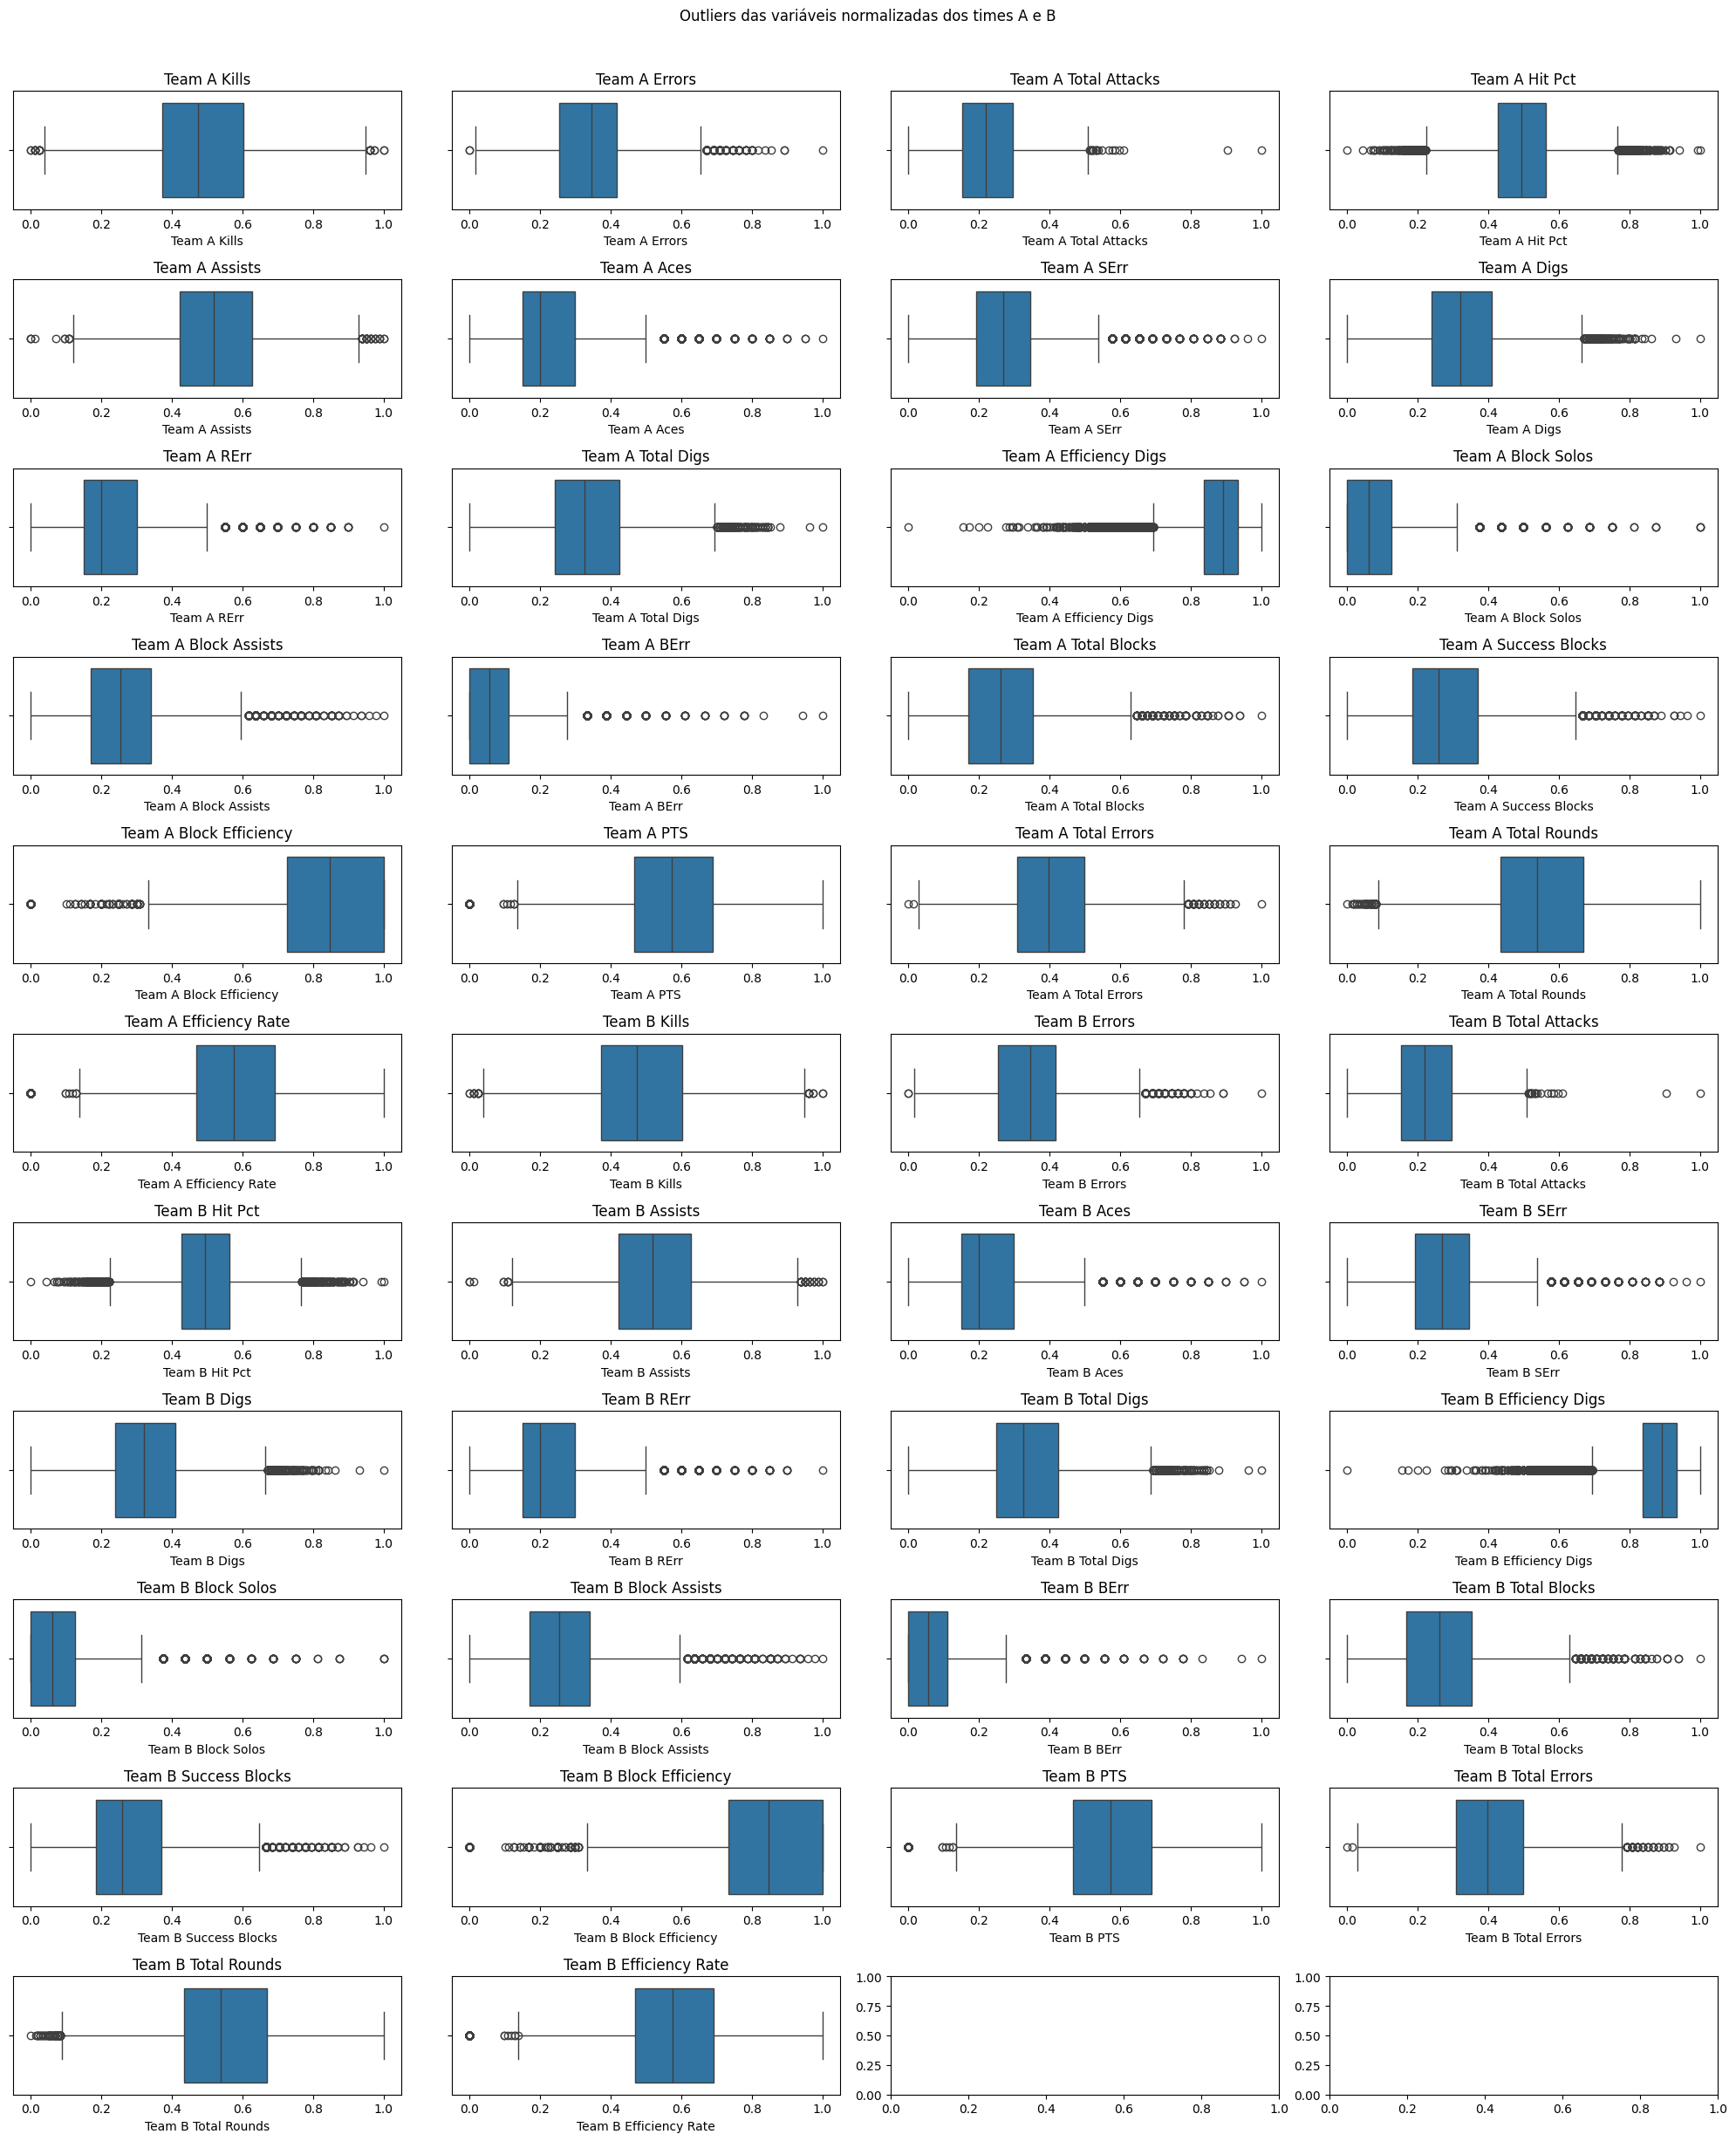

In [15]:
fig, axs = plt.subplots(11, 4, figsize=(20, 25))
fig.suptitle('Outliers das variáveis normalizadas dos times A e B')

axs = axs.ravel()

for i, col in enumerate(colunas_verify):
    sns.boxplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [9]:
from scipy import stats

z_scores = stats.zscore(df_norm[colunas_verify])
df_norm_clean = df_norm[(abs(z_scores) < 3).all(axis=1)]
df_norm_clean

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B Success Blocks,Team A Block Efficiency,Team B Block Efficiency,Team A Total Digs,Team B Total Digs,Team A Efficiency Digs,Team B Efficiency Digs,TeamA_ID,TeamB_ID,Match_ID
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,0.358974,0.345455,0.189560,0.427119,0.421687,...,0.148148,0.714286,0.800000,0.283688,0.276596,0.884615,0.941176,118,127,2899310916408534022
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,0.525641,0.472727,0.318681,0.421469,0.566265,...,0.351852,1.000000,0.904762,0.531915,0.453901,0.810345,0.822368,118,141,-8437588409357630576
4,2019-09-14,USC Upstate,George Washington,0,3.0,0.269231,0.290909,0.175824,0.394350,0.361446,...,0.148148,1.000000,0.400000,0.234043,0.354610,0.900000,0.951613,118,161,6300998361499773776
5,2019-09-14,USC Upstate,East Carolina,0,5.0,0.628205,0.381818,0.329670,0.505085,0.686747,...,0.222222,0.882353,0.600000,0.425532,0.496454,0.833333,0.890244,118,203,-6075019641389312269
6,2019-09-17,USC Upstate,N.C. A&T,1,4.0,0.615385,0.290909,0.222527,0.613559,0.602410,...,0.277778,1.000000,1.000000,0.354610,0.269504,0.806452,0.910000,118,27,-4246254204623390507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37644,2016-10-30,Elon,Delaware,0,4.0,0.564103,0.381818,0.274725,0.499435,0.626506,...,0.222222,0.666667,0.857143,0.382979,0.404255,0.931818,0.913043,197,260,-3168681651388803959
37645,2016-11-01,Elon,N.C. Central,1,3.0,0.551282,0.236364,0.159341,0.667797,0.602410,...,0.148148,0.600000,0.444444,0.269504,0.177305,0.940000,0.837838,197,93,-8965062542845588622
37646,2016-11-05,Elon,Col. of Charleston,0,3.0,0.384615,0.363636,0.211538,0.425989,0.421687,...,0.222222,0.500000,0.600000,0.312057,0.397163,0.892857,0.845588,197,174,7918146445281467354
37647,2016-11-07,Elon,UNCW,0,3.0,0.448718,0.490909,0.228022,0.401130,0.481928,...,0.388889,0.666667,0.840000,0.326241,0.262411,0.896552,0.969388,197,284,819597093055936531


## **Divisão de Features**
Como não temos nenhum especialista no domínio, dividi as features em categorias de acordo com vozes da minha cabeça e com aquela apresentação de estatísticas de volei que está na sessão de explicação das features

OBS: Estou analisando aqui ainda, quais colunas do time B por
**Gerais**
* Date
* Team A/ID
* Team B/ID
* Result
* S
* Match ID

**Ataque**
* Team A Kills: Número de ataques que resultaram em pontos
* Team A Errors: Erros de ataque cometidos
* Team A Total Attacks: Total de ataques realizados
* Team A Hit Pct: Percentual de acerto no ataque
* Team A Assists: Assistências para ataque

**Saque**
* Team A Aces: Pontos diretos de saque
* Team A SErr: Erros de saque

**Defesa**
* Team A Digs: Defesas bem-sucedidas
* Team A RErr: Erros de recepção

**Bloqueio**
* Team A Block Solos: Bloqueios individuais
* Team A Block Assists: Assistências em bloqueios
* Team A BErr: Erros de bloqueio

### **Dividindo Dataframe pelas categorias**

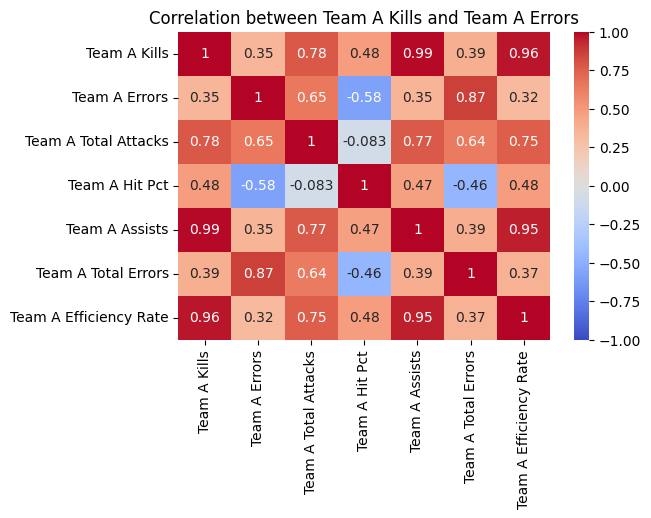

In [10]:
# Ataque
colunas_atq = [ 'Team A Kills',
       'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
       'Team A Assists', 'Team A Total Errors', 'Team A Efficiency Rate']
df_atq = df_norm_clean[colunas_atq]

correlation_matrix = df_atq.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Team A Kills and Team A Errors')
plt.show()

In [11]:
df_atq = df_atq.drop(columns=['Team A Assists'])

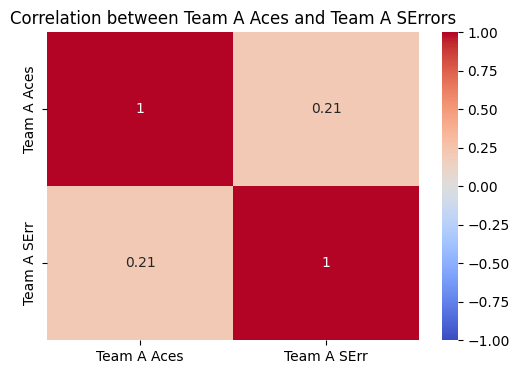

In [12]:
colunas_saq = ['Team A Aces', 'Team A SErr']
df_saq = df_norm_clean[colunas_saq]

correlation_matrix = df_saq.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Team A Aces and Team A SErrors')
plt.show()

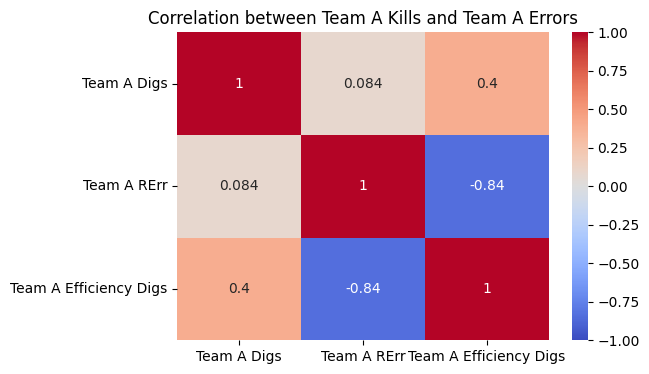

In [13]:
colunas_def = ['Team A Digs', 'Team A RErr', 'Team A Efficiency Digs']
df_def = df_norm_clean [colunas_def]

correlation_matrix = df_def.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Team A Kills and Team A Errors')
plt.show()

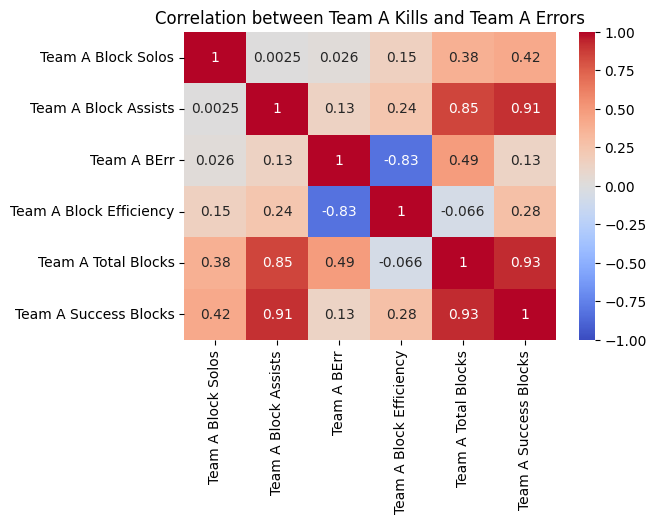

In [14]:
colunas_bloq = ['Team A Block Solos', 'Team A Block Assists', 'Team A BErr','Team A Block Efficiency','Team A Total Blocks', 'Team A Success Blocks']
df_bloq = df_norm_clean [colunas_bloq]

correlation_matrix = df_bloq.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Team A Kills and Team A Errors')
plt.show()

In [22]:
df_atq.head()

,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Total Errors,Team A Efficiency Rate
2,0.358974,0.345455,0.189560,0.427119,0.352941,0.430090
3,0.525641,0.472727,0.318681,0.421469,0.558824,0.690710
4,0.269231,0.290909,0.175824,0.394350,0.294118,0.372215
5,0.628205,0.381818,0.329670,0.505085,0.455882,0.695933
6,0.615385,0.290909,0.222527,0.613559,0.426471,0.681541


In [23]:
df_saq.head()

,Team A Aces,Team A SErr
2,0.10,0.153846
3,0.45,0.230769
4,0.10,0.230769
5,0.30,0.230769
6,0.15,0.384615


In [24]:
df_def.head()

,Team A Digs,Team A RErr,Team A Efficiency Digs
2,0.280822,0.20,0.884615
3,0.472603,0.55,0.810345
4,0.239726,0.15,0.900000
5,0.390411,0.40,0.833333
6,0.321918,0.40,0.806452


In [25]:
df_bloq.head()

,Team A Block Solos,Team A Block Assists,Team A BErr,Team A Block Efficiency,Team A Total Blocks,Team A Success Blocks
2,0.2500,0.042553,0.111111,0.714286,0.200000,0.185185
3,0.1250,0.425532,0.000000,1.000000,0.353846,0.444444
4,0.0000,0.255319,0.000000,1.000000,0.169231,0.222222
5,0.0625,0.276596,0.055556,0.882353,0.246154,0.277778
6,0.0000,0.425532,0.000000,1.000000,0.292308,0.370370


### **Teste Preliminar: KMeans**
Testei inicialmente, fazer semelhante ao que fizeram no artigo de base de rodas os testes do kmenas com n até no máximo o valor total de features daquela categoria. Mas os resultados deram péssimos, então testei 10 clusters só por desencargo de consciência

In [26]:
def kmeans_categoria(df):
    range_n_clusters = range(2,10)
    silhouette = []
    davies_bouldin = []

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters = n_clusters, n_init = 100 ,random_state = 42)
        kmeans.fit(df)
        labels = kmeans.labels_
        silhouette.append((n_clusters,silhouette_score(df, labels)))
        davies_bouldin.append((n_clusters,davies_bouldin_score(df,labels)))

    return davies_bouldin, silhouette

#### **KMeans para Ataque**

In [27]:
db_atq, sl_atq = kmeans_categoria(df_atq)
atq = {'Categoria': 'Ataque','Silhouette-Score':sl_atq,'Davies-Bouldin-Score':db_atq}
atq

{'Categoria': 'Ataque',
 'Silhouette-Score': [(2, 0.40074224309681045),
  (3, 0.39336567242687154),
  (4, 0.34312829474568807),
  (5, 0.33122722035718016),
  (6, 0.2881226909394713),
  (7, 0.27488192711858545),
  (8, 0.2644387858212116),
  (9, 0.25045913609185205)],
 'Davies-Bouldin-Score': [(2, 0.9843453871864993),
  (3, 0.8830879353991623),
  (4, 1.0359047910811932),
  (5, 0.9937046304632663),
  (6, 1.0686662654292003),
  (7, 1.0965731665081504),
  (8, 1.0607004953438404),
  (9, 1.1462716312941277)]}

#### **KMeans para Bloqueio**

In [28]:
db_bloq, sl_bloq = kmeans_categoria(df_bloq)
bloq = {'Categoria': 'Bloqueio','Silhouette-Score':sl_bloq,'Davies-Bouldin-Score':db_bloq}
bloq


{'Categoria': 'Bloqueio',
 'Silhouette-Score': [(2, 0.32079557373410883),
  (3, 0.33198615266604),
  (4, 0.28381600789211336),
  (5, 0.2861371909235178),
  (6, 0.2906580462028447),
  (7, 0.2981413819127918),
  (8, 0.2922122911384069),
  (9, 0.27824359004319765)],
 'Davies-Bouldin-Score': [(2, 1.1974852564714016),
  (3, 1.023875061405559),
  (4, 1.1829505449856337),
  (5, 1.0855421699729217),
  (6, 1.0720616565168266),
  (7, 1.0787633260116913),
  (8, 1.0888541049408096),
  (9, 1.0810998752146435)]}

#### **KMeans para Defesa**

In [29]:
db_def, sl_def = kmeans_categoria(df_def)
de = {'Categoria': 'Defesa','Silhouette-Score':sl_def,'Davies-Bouldin-Score':db_def}
de

{'Categoria': 'Defesa',
 'Silhouette-Score': [(2, 0.3641404435433826),
  (3, 0.3718396289761301),
  (4, 0.35073134117319926),
  (5, 0.3470698883177948),
  (6, 0.34624602005714267),
  (7, 0.3346012500966812),
  (8, 0.3381759747181031),
  (9, 0.33770033473369465)],
 'Davies-Bouldin-Score': [(2, 1.1060660060818117),
  (3, 0.9136494977304962),
  (4, 0.9561874768644357),
  (5, 0.8783654052204257),
  (6, 0.8466344628275917),
  (7, 0.8733502747232854),
  (8, 0.8463266392467055),
  (9, 0.8462550444849875)]}

#### **KMeans para Saque**

In [30]:
db_saq, sl_saq = kmeans_categoria(df_saq)
saq = {'Categoria': 'Saque','Silhouette-Score':sl_saq,'Davies-Bouldin-Score':db_saq}
saq

{'Categoria': 'Saque',
 'Silhouette-Score': [(2, 0.3673564051619381),
  (3, 0.36586898431444614),
  (4, 0.3559877683817086),
  (5, 0.3368303077851217),
  (6, 0.333451674257279),
  (7, 0.3466633306785505),
  (8, 0.3414947502309326),
  (9, 0.3489367472596191)],
 'Davies-Bouldin-Score': [(2, 1.0866174054586304),
  (3, 0.9655234342253562),
  (4, 0.8938570852097505),
  (5, 0.9246718255263687),
  (6, 0.9068205493500444),
  (7, 0.8501308027769715),
  (8, 0.8661025548423198),
  (9, 0.8416951535369728)]}

#### **Análise de Resultados**

In [31]:
dados = []
casos = [saq,de,atq,bloq]

for caso in casos:
    for sl_tupla, db_tupla in zip(caso['Silhouette-Score'], caso['Davies-Bouldin-Score']):
        n_clusters = sl_tupla[0]
        sl_score = sl_tupla[1]
        db_score = db_tupla[1]


        dados.append({
            'Categoria': caso['Categoria'],
            'n clusters': n_clusters,
            'Silhouette Score': sl_score,
            'Davies-Bouldin Score': db_score
        })
resultados = pd.DataFrame(dados)

print(resultados)

   Categoria  n clusters  Silhouette Score  Davies-Bouldin Score
0      Saque           2          0.367356              1.086617
1      Saque           3          0.365869              0.965523
2      Saque           4          0.355988              0.893857
3      Saque           5          0.336830              0.924672
4      Saque           6          0.333452              0.906821
5      Saque           7          0.346663              0.850131
6      Saque           8          0.341495              0.866103
7      Saque           9          0.348937              0.841695
8     Defesa           2          0.364140              1.106066
9     Defesa           3          0.371840              0.913649
10    Defesa           4          0.350731              0.956187
11    Defesa           5          0.347070              0.878365
12    Defesa           6          0.346246              0.846634
13    Defesa           7          0.334601              0.873350
14    Defesa           8 

### **Visualização Gráfica**

#### **Gráfico ataque**
o que apresentou o melhor db foi para 3 clusters

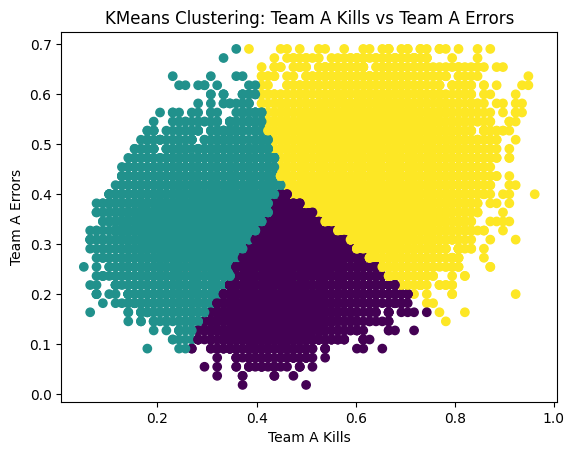

In [32]:
df_atq_cluster = df_atq
kmeans = KMeans(n_clusters=3)
df_atq_cluster['Cluster'] = kmeans.fit_predict(df_atq_cluster[['Team A Kills', 'Team A Errors']])

plt.scatter(df_atq_cluster['Team A Kills'], df_atq_cluster['Team A Errors'], c=df_atq_cluster['Cluster'], cmap='viridis')
plt.xlabel('Team A Kills')
plt.ylabel('Team A Errors')
plt.title('KMeans Clustering: Team A Kills vs Team A Errors')
plt.show()

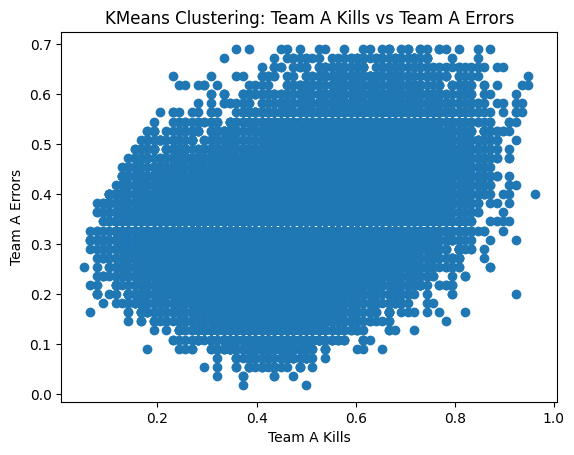

In [33]:
plt.scatter(df_atq_cluster['Team A Kills'], df_atq_cluster['Team A Errors'])
plt.xlabel('Team A Kills')
plt.ylabel('Team A Errors')
plt.title('KMeans Clustering: Team A Kills vs Team A Errors')
plt.show()

#### **Gráfico Bloqueio**
o melhor db foi para 3 clusters

<ipython-input-34-18f522ab56aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bloq_cluster['Cluster'] = kmeans.fit_predict(df_bloq_cluster[['Team A Block Assists', 'Team A BErr']])


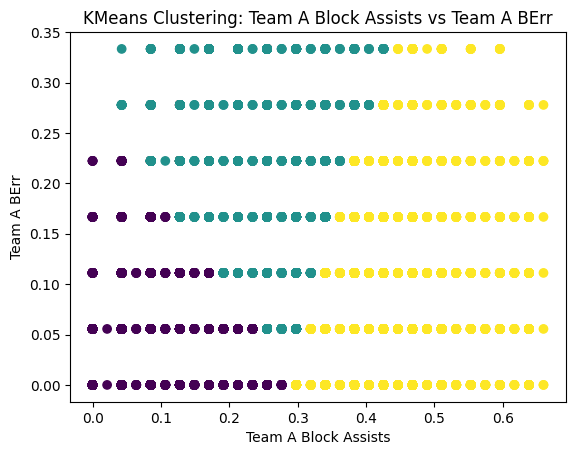

In [34]:
df_bloq_cluster = df_bloq
kmeans = KMeans(n_clusters=3)
df_bloq_cluster['Cluster'] = kmeans.fit_predict(df_bloq_cluster[['Team A Block Assists', 'Team A BErr']])

plt.scatter(df_bloq_cluster['Team A Block Assists'], df_bloq_cluster['Team A BErr'], c=df_bloq_cluster['Cluster'], cmap='viridis')
plt.xlabel('Team A Block Assists')
plt.ylabel('Team A BErr')
plt.title('KMeans Clustering: Team A Block Assists vs Team A BErr')
plt.show()

#### **Gráfico Defesa**
db = 3

<ipython-input-35-36935de35429>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_def_cluster['Cluster'] = kmeans.fit_predict(df_def_cluster[['Team A Digs', 'Team A RErr']])


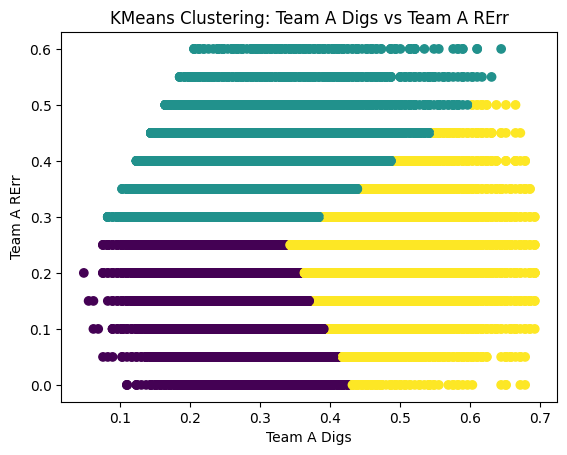

In [35]:
df_def_cluster = df_def
kmeans = KMeans(n_clusters=3)
df_def_cluster['Cluster'] = kmeans.fit_predict(df_def_cluster[['Team A Digs', 'Team A RErr']])

plt.scatter(df_def_cluster['Team A Digs'], df_def_cluster['Team A RErr'], c=df_def_cluster['Cluster'], cmap='viridis')
plt.xlabel('Team A Digs')
plt.ylabel('Team A RErr')
plt.title('KMeans Clustering: Team A Digs vs Team A RErr')
plt.show()

#### **Gráfico Saque**
db = 2

<ipython-input-36-0f41e5da3279>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saq_cluster['Cluster'] = kmeans.fit_predict(df_saq_cluster[['Team A Aces', 'Team A SErr']])


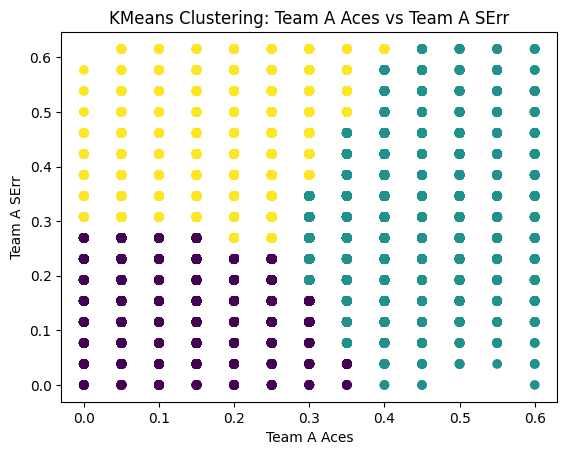

In [36]:
df_saq_cluster = df_saq
kmeans = KMeans(n_clusters=3)
df_saq_cluster['Cluster'] = kmeans.fit_predict(df_saq_cluster[['Team A Aces', 'Team A SErr']])

plt.scatter(df_saq_cluster['Team A Aces'], df_saq_cluster['Team A SErr'], c=df_saq_cluster['Cluster'], cmap='viridis')
plt.xlabel('Team A Aces')
plt.ylabel('Team A SErr')
plt.title('KMeans Clustering: Team A Aces vs Team A SErr')
plt.show()

In [15]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
categories = {
    # "Ataque": colunas_atq,
    # "Defesa": colunas_def,
    # "Saque": colunas_saq,
    "Bloqueio": colunas_bloq
}
# Models and hyperparameters
models = {
    "KMeans": {"n_clusters": [2, 3, 4, 5,, 6, 7, 8, 9, 10, 11, 12]},
    "DBSCAN": {"eps": [0.3, 0.5, 0.7], "min_samples": [5, 10]},
    "Hierarchical": {"n_clusters": [2, 3, 4], "linkage": ["ward", "complete", "average"]}
}

# Initialize a results list to store outcomes
results = []

# Loop through categories
for category, features in categories.items():
    # Select the data for the current category
    category_data = df[features].dropna()

    # Iterate through models
    for model_name, params in models.items():
        if model_name == "KMeans":
            for n_clusters in params["n_clusters"]:
                model = KMeans(n_clusters=n_clusters, random_state=42)
                labels = model.fit_predict(category_data)
                score = silhouette_score(category_data, labels)
                results.append({
                    "Category": category,
                    "Model": model_name,
                    "Parameters": f"n_clusters={n_clusters}",
                    "Silhouette Score": score
                })

        elif model_name == "DBSCAN":
            for eps in params["eps"]:
                for min_samples in params["min_samples"]:
                    model = DBSCAN(eps=eps, min_samples=min_samples)
                    labels = model.fit_predict(category_data)
                    if len(set(labels)) > 1:  # To ensure silhouette score is valid
                        score = silhouette_score(category_data, labels)
                    else:
                        score = np.nan
                    results.append({
                        "Category": category,
                        "Model": model_name,
                        "Parameters": f"eps={eps}, min_samples={min_samples}",
                        "Silhouette Score": score
                    })

        elif model_name == "Hierarchical":
            for n_clusters in params["n_clusters"]:
                for linkage in params["linkage"]:
                    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
                    labels = model.fit_predict(category_data)
                    score = silhouette_score(category_data, labels)
                    results.append({
                        "Category": category,
                        "Model": model_name,
                        "Parameters": f"n_clusters={n_clusters}, linkage={linkage}",
                        "Silhouette Score": score
                    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

c:\Users\gabri\OneDrive\Documents\Faculdade\2024.2\Projeto de Ciência de Dados\novo\volleyball-case-study\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gabri\OneDrive\Documents\Faculdade\2024.2\Projeto de Ciência de Dados\novo\volleyball-case-study\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


ModuleNotFoundError: No module named 'ace_tools'

In [16]:
results_df

,Category,Model,Parameters,Silhouette Score
0,Bloqueio,KMeans,n_clusters=2,0.312260
1,Bloqueio,KMeans,n_clusters=3,0.319407
2,Bloqueio,KMeans,n_clusters=4,0.278755
3,Bloqueio,KMeans,n_clusters=5,0.286845
4,Bloqueio,DBSCAN,"eps=0.3, min_samples=5",0.665473
5,Bloqueio,DBSCAN,"eps=0.3, min_samples=10",0.658664
6,Bloqueio,DBSCAN,"eps=0.5, min_samples=5",NaN
7,Bloqueio,DBSCAN,"eps=0.5, min_samples=10",NaN
8,Bloqueio,DBSCAN,"eps=0.7, min_samples=5",NaN
9,Bloqueio,DBSCAN,"eps=0.7, min_samples=10",NaN


### **Conclusões**

Pra quem não sabe Davies Bouldin quanto menor melhor e silhouette quanto maior melhor. Ou seja, resultados de merda 👍